# Mood-RL Model Fitting
## Section 1: Motivating model parameterization  
### Explaining the "Matt trick"
To fit reinforcement learning models with Stan, we utilize non-centered parameterizations (aka the "Matt trick"). This parameterization improves the efficiency of MCMC sampling by making the sampling space uniformly dense. Traditionally in Bayesian modeling, the inverse temperature ($\beta$) and learning rate ($\eta$) are sampled from directly (often with non-informative uniform priors). We will instead employ a two-step procedure where we will first sample from independent unit normal priors and then transform the samples into their appropriate parameter spaces:

> $\beta_{pr} \ \text{~} \mathcal{N}(0,1) $ 

> $\beta = C \cdot \text{Phi_approx}(\beta_{pr})$

> $\eta_{pr} \ \text{~} \mathcal{N}(0,1) $ 

> $\eta = \text{Phi_approx}(\eta_{pr}) $

where *Phi_approx* is a fast approximation of the cumulative unit normal [(Bowling et al., 2009)](http://www.jiem.org/index.php/jiem/article/view/60):

> $\text{Phi_approx}(x) = \text{logit}^{-1}(0.07056 \ x^3 + 1.5976 \ x) $

As an approximation of the cumulative unit normal, the *Phi_approx* function conveniently scales its inputs to be in the range $x \in (0, 1)$. As such, samples from $\eta_{pr}$ are of appropriate scale following transformation. Because values of $\beta$ are normally much larger than 1, a scaling function, $C$, is used to scale the samples of $\beta_{pr}$ to an appropriate range. For example, a user would set $C=20$ to sample $\beta \in (0,20)$.

For details, see the [Stan users manual](http://mc-stan.org/users/documentation/) (section 28.6). The [*hBayesDM*](https://github.com/CCS-Lab/hBayesDM) and [*fitr*](https://github.com/abrahamnunes/fitr) packages provided the templates for fitting these models.

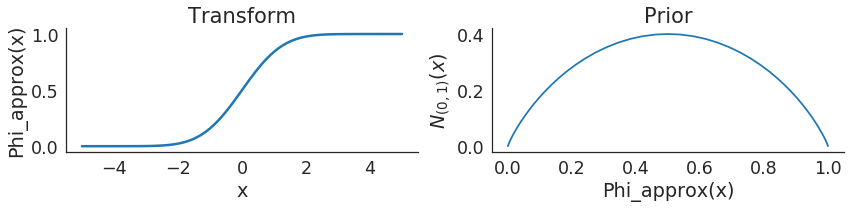

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import norm
from scripts.utilities import phi_approx
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)
%matplotlib inline

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,3))
x = np.linspace(-5,5,101)

## Plot Phi_approx function.
axes[0].plot(x, phi_approx(x), lw=2.5)
axes[0].set(xlabel='x', ylabel='Phi_approx(x)', title='Transform')

## Plot prior.
axes[1].plot(phi_approx(x), norm(0,1).pdf(x))
axes[1].set(xlabel='Phi_approx(x)', ylabel=r'$N_{(0,1)}(x)$', title='Prior')

sns.despine()
plt.tight_layout()

**Figure 1:** Visualizing the *Phi_approx* function. (Left) The transformation of arbitrary values, $x$, through *Phi_approx*. (Right) The probability density of *Phi_approx* scaled values, $x$, sampled from a unit normal distribution.

### Hierarchical parameterization
Non-centered parameterizations are especially useful for hierarchical models, where parameters may vary dramatically in scale (resulting in sampling issues). As such, all subject parameters are similarly sampled from a unit normal prior and transformed. To make the model hierarchical, i.e. to enforce partial pooling, subject-level parameters ($\beta_i, \eta_i$) are estimated using a similar two-step procedure:

> $\beta_{pr, i} \ \text{~} \mathcal{N}(0,1) $ 

> $\beta_i = C \cdot \text{Phi_approx}(\beta_{pr,\mu} + \sigma_{\beta} \cdot \beta_{pr,i})$

> $\eta_{pr,i} \ \text{~} \mathcal{N}(0,1) $ 

> $\eta_i = \text{Phi_approx}(\eta_{pr,\mu} + \sigma_{\eta} \cdot \eta_{pr,i}) $

where $\beta_{pr,\mu}$ and $\eta_{pr,\mu}$ are the group-level inverse temperature and learning rates, respectively; and $\sigma$ captures the variance of the subject-level parameters around the group mean. As above, the group-level parameters are also sampled through a unit normal prior. The variances can be sampled through a half-cauchy distribution or gamma distribution.  

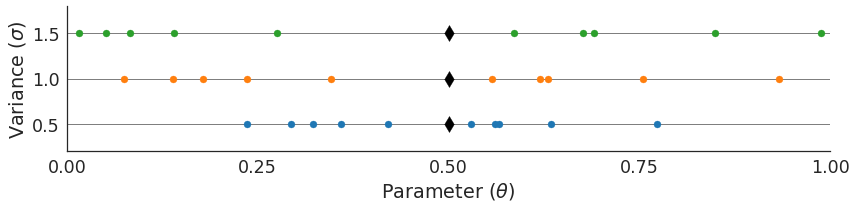

In [2]:
## Randomly generate arbitrary subject-level parameters.
np.random.seed(47404)
theta = np.random.normal(0,1,10)
sigma = [0.5,1,1.5]

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
for s in sigma:
    ax.scatter(phi_approx(0 + s * theta), np.ones_like(theta)*s)
ax.scatter(phi_approx(np.zeros(3)), [0.5,1,1.5], s=130, marker='d', color='k')
    
## Add info.
ax.hlines(sigma, 0, 1, lw=0.5, zorder=0)
ax.set(xlim=(0,1), xticks=np.linspace(0,1,5), xlabel=r'Parameter ($\theta$)', 
       ylim=(0.2, 1.8), yticks=sigma, ylabel=r'Variance ($\sigma$)')
    
sns.despine()
plt.tight_layout()

**Figure 2:** Visualizing the hierarchical model. Arbitrarily sampled subject-level variables, $\theta_i$ (color circles), are distributed around a group-level variable, $\theta_\mu$ (diamonds). The variance of their distribution is dictated by $\sigma$. When $\sigma < 1$, the subject-level parameters shrink towards group-level value; when $\sigma > 1$, the subject-level parameters move away from group-level value.

### Prior on the mood-bias parameter ($f$) 

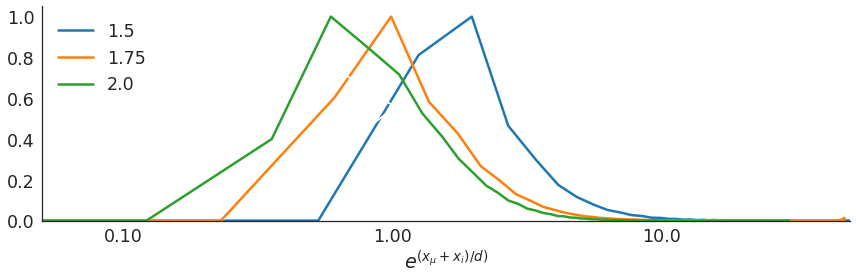

In [ ]:
np.random.seed(47404)

## Simulate data.
f_pr = np.random.multivariate_normal(np.zeros(2), np.identity(2), int(1e6))
divisor = [1.5, 1.75, 2.0]

fig, ax = plt.subplots(1,1,figsize=(12,4))
for d in divisor:
    
    ## Compute f (assumings sigma = 1).
    f = np.exp( np.sum(f_pr, axis=1) / d )
    
    ## Plot.
    sns.kdeplot(f, color='w', ax=ax)
    line = ax.lines[-1]
    xdata, ydata = line.get_xdata(), line.get_ydata()
    ax.plot(xdata, ydata/ydata.max(), lw=2.5, label=d)
    
ax.set_xscale('log')
ax.set(xlim=(0.05, 50), xticks=np.logspace(-1,2,4), xlabel=r'$e^{(x_\mu + x_i)/d)}$', 
       ylim=(0,1.05), xticklabels=['0.10','1.00','10.0','100.'])
ax.legend(loc=2)
sns.despine()
plt.tight_layout()

## Section 2: Model fitting

In [ ]:
import os, pystan
import _pickle as cPickle
from pandas import DataFrame, read_csv
from scripts.utilities import check_div, check_energy, check_treedepth, initialize_params
%load_ext jupyternotify

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Select model.
model_name = False

## Sampling parameters.
samples = 1250
warmup = 1000
chains = 4
thin = 1
n_jobs = 4

## Initialization parameters.
init = False

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load and prepare behavior data.
data = read_csv('data/moodRL_data.csv')
data = data[data.Block < 4]
data = data.fillna(-1)

## Load and prepare ratings data.
ratings = read_csv('data/moodRL_ratings.csv')
ratings = ratings[ratings.Variable=='Mood']

## Load and prepare metadata.
metadata = read_csv('data/moodRL_metadata.csv')

## Define metadata.
N = data.Datetime.unique().size
B = data.Block.max()
T = data.Trial.max()
dt = data.Datetime.unique()

## Extract and prepare task data.
X = data[['M1','M2']].values.reshape(N,B,T,2)
Y = data.Choice.values.reshape(N,B,T,1)
Y = np.where( np.any(np.equal(X, Y), axis=-1), np.argmax(np.equal(X, Y), axis=-1) + 1, -1 )
R = data.Outcome.values.reshape(N,B,T)
R = np.where(R > 0, 1, 0)

## Extract and prepare mood data.
M = ratings.loc[ratings.Trial>0, 'Rating'].values.reshape(N,B,3) / 4

h12 = ratings.loc[ratings.Trial==0, 'Rating'].values.reshape(N,2) / 4
h12 = np.where(h12==-1, -0.99, np.where(h12==1, 0.99, h12))
h12 = np.arctanh(h12)

## Extract and prepare WoF data.
WoF = np.sign(metadata.WoF.values) * 28

## Organize data dictionary.
dd = dict(N=N, B=B, T=T, X=X, Y=Y, R=R, M=M, h12=h12, WoF=WoF)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit model with Stan.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

if model_name:

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Model fitting and diagnostics.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Define initialization.
    if init: init = initialize_params(N, chains)
    else: init = 'random'
    

    ## Fit model.
    file = 'stan_models/%s' %model_name
    fit = pystan.stan(file=file, data=dd, iter=samples, warmup=warmup, thin=thin,
                      chains=chains, init=init, n_jobs=n_jobs, seed=47404)
    check_div(fit); check_treedepth(fit); check_energy(fit)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Save data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Create out-directory.
    out_dir = 'stan_fits/%s' %model_name.replace('.stan','')
    if not os.path.isdir(out_dir): os.makedirs(out_dir)

    ## Save summary file.
    summary = fit.summary()
    summary = DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])
    summary.to_csv(os.path.join(out_dir, 'summary.csv'))

    ## Save contents of StanFit.
    extract = fit.extract()
    for k, v in dd.items(): extract[k] = v
    with open(os.path.join(out_dir, 'StanFit.pickle'), 'wb') as f: cPickle.dump(extract, f)
        
    print('Done.')

<IPython.core.display.Javascript object>

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_23f1fef7ba18266d90051cbc776bccab NOW.
/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


## Posterior predictive check
Drawing inspiration from [Gelman (2000)](http://www.stat.columbia.edu/~gelman/research/published/dogs.pdf)

In [ ]:
from scripts.psis import psisloo

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define Stan models.
model_names = ['moodRL_npool_base.stan', 'moodRL_ppool_base.stan',
               'moodRL_ppool_mood_mod.stan']
  
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(12,9))
sns.set_context('notebook', font_scale=1.5)
colors = sns.color_palette(n_colors=len(model_names))

## Customize axes with GridSpec.
gs = gridspec.GridSpec(3, 1)
gs.update(left=0.05, right=0.95, bottom=0.35,  top=0.95, hspace=0.05)
ax1, ax2, ax3 = plt.subplot(gs[0]), plt.subplot(gs[1]),  plt.subplot(gs[2])

gs = gridspec.GridSpec(1, 2)
gs.update(left=0.05, right=0.95, bottom=0.05,  top=0.225, hspace=0)
ax4, ax5 = plt.subplot(gs[0]), plt.subplot(gs[1])

for i, model_name in enumerate(model_names):
    
    ## Load StanFit file.
    f = 'stan_fits/%s/StanFit.pickle' %model_name.replace('.stan','')
    with open(f, 'rb') as f: extract = cPickle.load(f)
        
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plot group-level performance.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Extract data and compute optimal choice.
    optimal_choice = np.argmax(extract['X'], axis=-1)
    Y_obs = np.equal(extract['Y']-1, optimal_choice).astype(int)
    Y_pred = np.array([np.equal(sample, optimal_choice) for sample in extract['Y_pred']-1]).astype(int)
    
    ## Mask missing data.
    missing = extract['Y'] < 0
    Y_obs = np.where(missing, np.nan, Y_obs)
    Y_pred = np.array([np.where(missing, np.nan, sample) for sample in Y_pred])
    
    ## Compute average over subjects.
    Y_obs = np.nanmean(Y_obs, axis=0)
    Y_pred = np.apply_over_axes(np.nanmean, Y_pred, [0,1]).squeeze()
    n_blocks, n_trials = Y_obs.shape
    
    for block in np.arange(n_blocks):
        
        ## Define trial numbers.
        trials = np.arange(n_trials) + block * n_trials
        trials += 1
        
        ## Plot.
        if not i: ax1.plot( trials, Y_obs[block], lw=2.5, color='grey', alpha=0.8 )
        ax1.plot( trials, Y_pred[block], lw=2.5, color=colors[i], alpha=0.8 )
        
    ## Add info.
    ax1.vlines([42.5, 84.5], 0, 1, lw=1.5, color='k', zorder=10)
    ax1.set(xlim=(0.5, 126), xticks=[], xlabel='', ylim=(0.35, 1.01), 
            ylabel='Optimal Choice', title='Posterior Predictive Checks')
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plot group-level mood change.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Extract mood data.
    M_obs = extract['M']
    M_pred = np.median(extract['M_pred'], axis=0)
    
    ## Compute average across subjects by WoF outcome.
    WoF = metadata.WoF.values
    M_obs = np.array([M_obs[WoF == v].mean(axis=0) for v in [7,-7]])
    M_pred = np.array([M_pred[WoF == v].mean(axis=0) for v in [7,-7]])
    
    for block in np.arange(n_blocks):
        
        ## Define trial numbers.
        trials = np.array([7,21,35]) + block * n_trials
        
        for outcome, ax in enumerate([ax2, ax3]):
            
            if not i: ax.plot(trials, M_obs[outcome, block], marker='o',
                              lw=2.5, color='grey', alpha=0.8)
            ax.plot(trials, M_pred[outcome, block], marker='o',
                    lw=2.5, color=colors[i], alpha=0.8)
    
    ## Add info.
    for ax, ylim, title in zip([ax2,ax3], [(-0.1, 1.1), (-0.6,0.6)], ['WoF Win', 'WoF Loss']):
        ax.vlines([42.5, 84.5], -3, 3, lw=1.5, color='k', zorder=10)
        ax.hlines(0, 0, n_trials*n_blocks+1, linestyle='--', alpha=0.1, zorder=0)
        ax.set(xlim=(0.5,126), xticks=[], ylim=ylim, ylabel='Mood')
        ax.annotate(title, (0,0), (0.5,0.9), xycoords='axes fraction', ha='center', fontsize=16)
    ax.set(xticks=np.arange(7,126,14), xlabel='Trial')

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plot WAIC.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Extract log-likelihood values.
    Y_log_lik = extract['Y_log_lik']
    M_log_lik = extract['M_log_lik']
    n_samp, n_subj, n_block, n_trial = Y_log_lik.shape
    
    ## Reshape data.
    Y_log_lik = Y_log_lik.reshape(n_samp, n_subj*n_block*n_trial)
    M_log_lik = M_log_lik.reshape(n_samp, n_subj*n_block*3)
    
    ## Remove log-likelihoods corresponding to missing data.
    Y_log_lik = np.where(Y_log_lik, Y_log_lik, np.nan)
    missing = np.isnan(Y_log_lik).mean(axis=0) > 0
    Y_log_lik = Y_log_lik[:,~missing] 
    
    ## Compute PSIS-LOO.
    Y_loo, _, _ = psisloo(Y_log_lik)
    M_loo, _, _ = psisloo(M_log_lik)
    
    ## Plot.
    ax4.bar(i, -2*Y_loo, 1, color=colors[i])
    ax4.set(ylim=(3650, 3750), ylabel='PSIS-LOO', title='Model Fits: Choice')
    
    ax5.bar(i, -2*M_loo, 1, color=colors[i])
    ax5.set(ylabel='PSIS-LOO', title='Model Fits: Mood')
        
sns.despine()

# Code scraps (will soon disappear)

#### Group-level mood

In [ ]:
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import pearsonr

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Extract.
M_obs = extract['M'].reshape(n_subj, n_block * 3)
M_pred = np.median(extract['M_pred'],axis=0).reshape(n_subj, n_block * 3)

## Sort.
ix = np.argsort(M_obs.mean(axis=-1))
M_obs = M_obs[ix]
M_pred = M_pred[ix]

## Store as table.
data = DataFrame(np.vstack([M_obs.flatten(), M_pred.flatten()]).T,
                 columns=('Observed','Predicted'))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot group-level mood checks.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(3,1,figsize=(12,9))
cmap = sns.diverging_palette(250, 10, s=90, l=50, center="dark", as_cmap=True)

## Plot mood heatmaps.
for ax, arr, title in zip(axes[:2], [M_obs, M_pred], ['Observed','Predicted']):
    
    ## Setup colorbar.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    ## Plot heatmap.
    sns.heatmap(arr, vmin=-1, vmax=1, cmap=cmap, 
                cbar_kws=dict(label='Mood'), ax=ax, cbar_ax=cax)
    
    ## Add info.
    ax.hlines(np.arange(ix.size), 0, 9, lw=0.05, color='w')
    ax.vlines([3,6], 0, ix.size, lw=5, color='w')
    ax.set(xticks=[1.5,4.5,7.5], xticklabels=['Block 1','Block 2','Block 3'], 
           ylabel='Participants', title=title)
    ax.invert_yaxis()
    
    ## Update colorbar.
    cbar = ax.collections[0].colorbar
    cbar.set_ticks(np.linspace(-1,1,5) * 0.85)
    cbar.ax.set_yticklabels(['%0.2f' %i for i in np.linspace(-1,1,5)], fontsize=14)
    
## Plot scatterplot.
m = np.unique(data.Observed)
cmap = sns.diverging_palette(250, 10, s=90, l=50, n=m.size, center="dark")

sns.stripplot('Observed', 'Predicted', data=data, palette=cmap, jitter=True, alpha=0.3, ax=axes[2])
for x, y, color in zip(range(ix.size), m, cmap): 
    axes[2].scatter(x,y,s=300,marker='d',color=color,edgecolor='w',lw=1.5)
    
## Add info.
axes[2].set(ylim=(-1.05,1.05), yticks=np.linspace(-1,1,5))
axes[2].annotate(r'$r = %0.3f$' %pearsonr(M_obs.flatten(), M_pred.flatten())[0], xy=(0,0),
                xytext=(0.025,0.90), xycoords='axes fraction', fontsize=18)
sns.despine(ax=axes[2])
plt.tight_layout()

#### Group-level parameter pair plots

In [ ]:
## Assemble group-level parameters into table.
data = DataFrame(np.vstack([extract['mu_beta'],extract['mu_eta_v'],
                            extract['mu_eta_h'],extract['mu_f']]).T,
                 columns=(r'$\beta$', r'$\eta_v$',r'$\eta_h$',r'$f$'))

## Plot.
g = sns.PairGrid(data, aspect=1.5)
g.map_lower(plt.scatter, s=25, linewidth=1.5, color='none', edgecolor='#1f77b4', alpha=0.4)
g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_diag(sns.distplot, kde=False, hist_kws=dict(edgecolor='w', linewidth=0.5, alpha=0.9));

In [ ]:
## Assemble group-level parameters into table.
data = DataFrame(extract['sigma'], columns=(r'$\sigma_\beta$', r'$\sigma_v$', 
                                            r'$\sigma_h$',r'$\sigma_f$'))

## Plot.
g = sns.PairGrid(data, aspect=1.5)
g.map_lower(plt.scatter, s=25, linewidth=1.5, color='none', edgecolor='#1f77b4', alpha=0.4)
g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_diag(sns.distplot, kde=False, hist_kws=dict(edgecolor='w', linewidth=0.5, alpha=0.9));

In [ ]:
from scipy.stats import spearmanr

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load and extract HPS data.
metadata = read_csv('data/moodRL_metadata.csv')
HPS = metadata.IPIP_hps

## Extract data.
f = np.median(extract['f'], axis=0)
M_pred = extract['M'].reshape(f.size, 9)

## Store data.
xdata = [np.median(M_pred, axis=-1), np.std(M_pred, axis=-1), HPS]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot mood bias parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4),sharey=True)
xlabels = ['Mood Average', 'Mood Variance', 'HPS']

for i, ax, arr, xlabel in zip(range(3), axes, xdata, xlabels):
    
    ## Plot.
    sns.regplot(arr, np.log10(f), ax=ax)

    ## Add info.
    ax.set(xlabel=xlabel, yticks=[-1,0,1], yticklabels=[0.1, 1.0, 10.], ylim=(-1.2, 1.5));
    ax.annotate(r'$r_s = %0.3f, p = %0.3f$' %spearmanr(arr, np.log10(f)), xy=(0,0),
                xytext=(1,0.05), xycoords='axes fraction', fontsize=16, ha='right')
    if not i: ax.set_ylabel(r'Mood bias ($f$)')

ax.set_xlim(1.3, 4)
sns.despine()
plt.tight_layout()